https://youtu.be/oBIkr7CAE6g

Binary semantic segmentation using U-Net
Dataset: https://www.epfl.ch/labs/cvlab/data/data-em/

In [1]:
from tensorflow.keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import glob

In [3]:
image_directory =Image.open(r"C:\Users\HARSHITA\Downloads\training.tif")
mask_directory = Image.open(r"C:\Users\HARSHITA\Downloads\training_groundtruth.tif")


In [4]:


def patchify_image(image, patch_size):
    width, height = image.size
    patches = []
    for x in range(0, width, patch_size):
        for y in range(0, height, patch_size):
            patch = image.crop((x, y, x + patch_size, y + patch_size))
            patches.append(patch)
    return patches

# Load the image
image_path = r"C:\Users\HARSHITA\Downloads\training.tif"
image = Image.open(image_path)

mask_path = r"C:\Users\HARSHITA\Downloads\training_groundtruth.tif"
mask = Image.open(mask_path)
# Patchify the image
patch_size = 256
images = patchify_image(image, patch_size)
masks = patchify_image(mask, patch_size)

In [5]:
len(images)

12

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
SIZE = 256
num_images = 100

Load images and masks in order so they match

In [11]:
image_names = glob.glob(r"C:\Users\HARSHITA\OneDrive\Documents\patches\images\*.tif")
print(len(image_names))

1980


In [13]:
image_names.sort()


In [14]:
image_names_subset = image_names[0:num_images]
print(len(image_names_subset))

100


In [15]:
images = [cv2.imread(img, 0) for img in image_names_subset]
print(len(images))

100


In [16]:
image_dataset = np.array(images)
image_dataset = np.expand_dims(image_dataset, axis = 3)

Read masks the same way.

In [17]:
mask_names = glob.glob(r"C:\Users\HARSHITA\OneDrive\Documents\patches\masks\*.tif")
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)

In [18]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (100, 256, 256, 1)
Mask data shape is:  (100, 256, 256, 1)
Max pixel value in image is:  225
Labels in the mask are :  [  0 255]


In [22]:
#scaler = MinMaxScaler()

In [23]:
#test_image_data=scaler.fit_transform(image_dataset_uint8.reshape(-1, image_dataset_uint8.shape[-1])).reshape(image_dataset_uint8.shape)

In [19]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #PIxel values will be 0 or 1

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


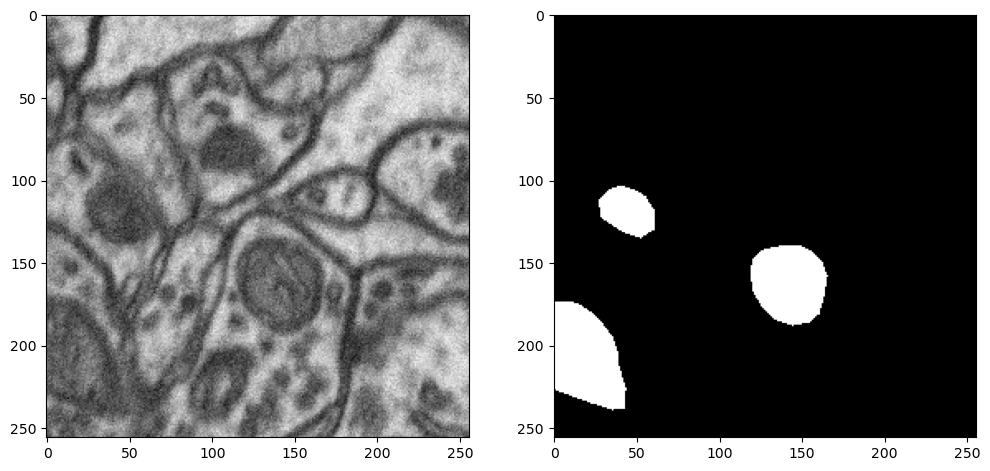

In [23]:
#Sanity check, view few mages
import random

image_number = random.randint(0, len(X_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap='gray')
plt.show()

In [24]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [25]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [26]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normaliz

 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 16, 16, 1024)         4719616   ['max_pooling2d_3[0][0]']     
                                                                                                  
 batch_normalization_8 (Bat  (None, 16, 16, 1024)         4096      ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_8 (Activation)   (None, 16, 16, 1024)         0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 

                                                                                                  
 conv2d_transpose_3 (Conv2D  (None, 256, 256, 64)         32832     ['activation_15[0][0]']       
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 256, 256, 128)        0         ['conv2d_transpose_3[0][0]',  
 )                                                                   'activation_1[0][0]']        
                                                                                                  
 conv2d_16 (Conv2D)          (None, 256, 256, 64)         73792     ['concatenate_3[0][0]']       
                                                                                                  
 batch_normalization_16 (Ba  (None, 256, 256, 64)         256       ['conv2d_16[0][0]']           
 tchNormal

In [28]:
history = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=25,
                    validation_data=(X_test, y_test),
                    shuffle=False)


Epoch 1/25
5/5 [==============================] - 173s 35s/step - loss: 0.0268 - accuracy: 0.9959 - val_loss: 0.5717 - val_accuracy: 0.7058
Epoch 2/25
5/5 [==============================] - 186s 38s/step - loss: 0.0256 - accuracy: 0.9961 - val_loss: 0.6280 - val_accuracy: 0.6596
Epoch 3/25
5/5 [==============================] - 184s 38s/step - loss: 0.0245 - accuracy: 0.9962 - val_loss: 0.3614 - val_accuracy: 0.8737
Epoch 4/25
5/5 [==============================] - 175s 36s/step - loss: 0.0232 - accuracy: 0.9965 - val_loss: 0.3393 - val_accuracy: 0.9133
Epoch 5/25
5/5 [==============================] - 181s 37s/step - loss: 0.0225 - accuracy: 0.9965 - val_loss: 0.2270 - val_accuracy: 0.9641
Epoch 6/25
5/5 [==============================] - 177s 36s/step - loss: 0.0225 - accuracy: 0.9962 - val_loss: 0.3188 - val_accuracy: 0.9132
Epoch 7/25
5/5 [==============================] - 174s 35s/step - loss: 0.0240 - accuracy: 0.9954 - val_loss: 0.3121 - val_accuracy: 0.9270
Epoch 8/25
5/5 [====

In [ ]:
#Save the model for future use
model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial118_mitochondria_25epochs.hdf5')

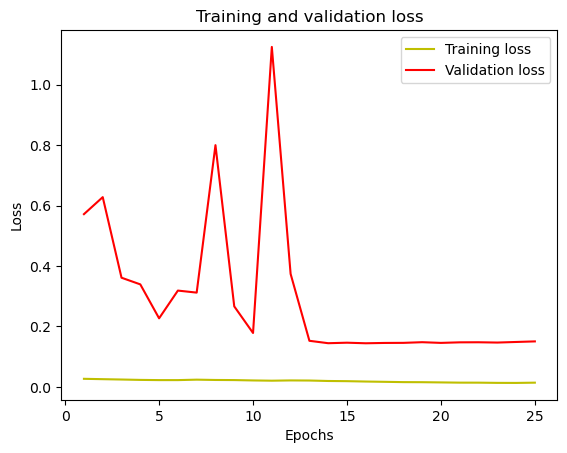

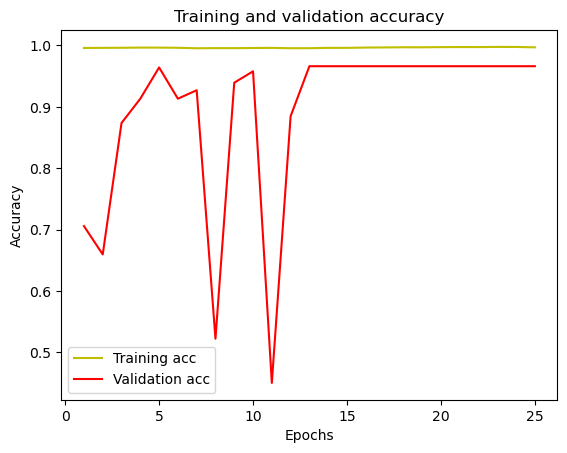

In [29]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
#Load previously saved model
from keras.models import load_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/saved_models/tutorial118_mitochondria_25epochs.hdf5", compile=False)


OSError: No file or directory found at /content/drive/MyDrive/Colab Notebooks/saved_models/tutorial118_mitochondria_25epochs.hdf5

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
print("Image dataset shape:", image_dataset.shape)
print("Mask dataset shape:", mask_dataset.shape)